In [1]:
%conda install xgboost -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.5
  latest version: 4.7.10

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn, sklearn.linear_model, sklearn.utils, sklearn.model_selection
import statsmodels.api as smf
import xgboost

import tensorflow.keras as keras
import tensorflow.keras.layers as L

from IPython.display import SVG

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

pd.plotting.register_matplotlib_converters()
plt.rcParams['figure.dpi'] = 120
sns.set_style('darkgrid')

### Load Data, Basic Cleaning

In [3]:
df = pd.read_csv('../beijing_pollution.csv')

In [4]:
date_cols = ['year', 'month', 'day', 'hour']
df = df.set_index(pd.to_datetime(df[date_cols])).drop(date_cols + ['No'], axis='columns')

In [5]:
df = df.asfreq('H')

In [6]:
df = df.fillna(method='pad')

In [7]:
df['Annual_Cos'] = np.cos(df.index.dayofyear/365*2*np.pi)
df['Annual_Sin'] = np.sin(df.index.dayofyear/365*2*np.pi)
df['Daily_Cos'] = np.cos(df.index.hour/24*2*np.pi)
df['Daily_Sin'] = np.sin(df.index.hour/24*2*np.pi)
df['weekday'] = df.index.weekday
df = pd.concat([df, pd.get_dummies(df.cbwd,)], axis='columns').dropna()
print(df['cbwd'].unique().tolist())
df.drop('cbwd', inplace=True, axis='columns')

['SE', 'cv', 'NW', 'NE']


In [8]:
df.head()

pm2.5  DEWP  TEMP    PRES   Iws  Is  Ir  Annual_Cos  \
2010-01-02 00:00:00  129.0   -16  -4.0  1020.0  1.79   0   0    0.999407   
2010-01-02 01:00:00  148.0   -15  -4.0  1020.0  2.68   0   0    0.999407   
2010-01-02 02:00:00  159.0   -11  -5.0  1021.0  3.57   0   0    0.999407   
2010-01-02 03:00:00  181.0    -7  -5.0  1022.0  5.36   1   0    0.999407   
2010-01-02 04:00:00  138.0    -7  -5.0  1022.0  6.25   2   0    0.999407   

                     Annual_Sin  Daily_Cos  Daily_Sin  weekday  NE  NW  SE  cv  
2010-01-02 00:00:00    0.034422   1.000000   0.000000        5   0   0   1   0  
2010-01-02 01:00:00    0.034422   0.965926   0.258819        5   0   0   1   0  
2010-01-02 02:00:00    0.034422   0.866025   0.500000        5   0   0   1   0  
2010-01-02 03:00:00    0.034422   0.707107   0.707107        5   0   0   1   0  
2010-01-02 04:00:00    0.034422   0.500000   0.866025        5   0   0   1   0

In [9]:
df.columns

Index(['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'Annual_Cos',
       'Annual_Sin', 'Daily_Cos', 'Daily_Sin', 'weekday', 'NE', 'NW', 'SE',
       'cv'],
      dtype='object')

In [10]:
X_cols = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir',
       'Annual_Cos', 'Annual_Sin', 'weekday', 'NE', 'NW', 'SE', 'cv']

X = df[X_cols].astype(np.float32)
Y = df['pm2.5'].astype(np.float32)

In [11]:
in_train_set = X.index < '2014-01-01'
X_train, X_test = X[in_train_set], X[~in_train_set]
Y_train, Y_test = Y[in_train_set], Y[~in_train_set]

## Zeroth order model -- Time Naive XGBoost Model

In [12]:
splitter = sklearn.model_selection.TimeSeriesSplit(n_splits=8)

for train_indices, test_indices in splitter.split(X_train):
    xgbr = xgboost.XGBRegressor(n_estimators=2000, objective='reg:linear', n_jobs=-1, learning_rate=0.05, reg_lambda=5, random_state=3920)

    xgbf = xgbr.fit(X_train.iloc[train_indices], Y_train.iloc[train_indices])
    
    y_ = Y_train.iloc[test_indices]
    y_hat_ = xgbf.predict(X_train.iloc[test_indices])
    
    print(sklearn.metrics.mean_squared_error(y_, y_hat_))
    
xgbr = xgboost.XGBRegressor(n_estimators=2000, objective='reg:linear', n_jobs=-1, random_state=3920)
xgbf = xgbr.fit(X_train, Y_train)

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


10995.35


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


7537.0225


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


4825.674


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


8157.8647


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


3750.7993


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


7354.3037


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


3921.9395


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


4830.6694


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [13]:
sklearn.metrics.mean_squared_error(Y_test, xgbf.predict(X_test))

4775.495

In [14]:
sklearn.metrics.r2_score(Y_test, xgbf.predict(X_test))

0.45777005526268877

In [15]:
np.argsort(xgbf.feature_importances_)[::-1]

array([11,  0,  6, 10,  3,  9,  7,  8,  2, 12,  1,  5,  4])

In [16]:
X_train.columns[np.argsort(xgbf.feature_importances_)[::-1]]

Index(['SE', 'DEWP', 'Annual_Cos', 'NW', 'Iws', 'NE', 'Annual_Sin', 'weekday',
       'PRES', 'cv', 'TEMP', 'Ir', 'Is'],
      dtype='object')

## ARIMA Model

There is a type of model fitting procedure where a linear model is used on the exogenous variables, and then an ARIMA model is used on the residuals. That's what I'm modeling here, with the change of using the XGBoost in place of the linear model for the exogenous variables.

In [17]:
xgb_residuals = Y_train.values - xgbf.predict(X_train)

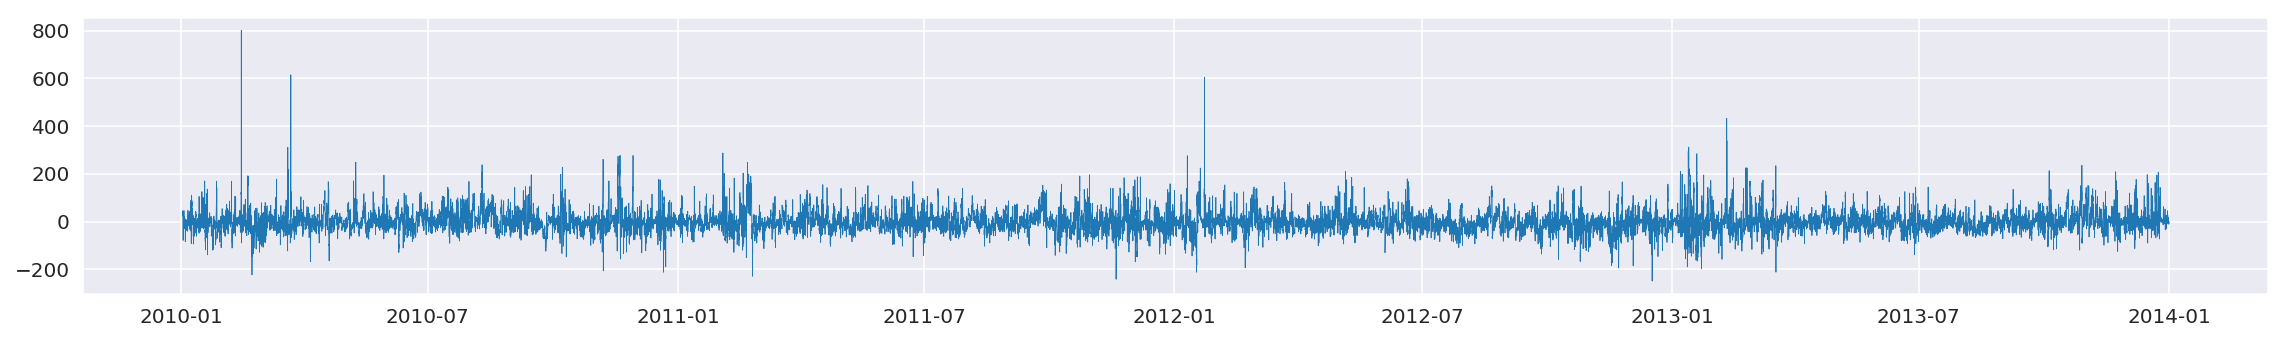

In [18]:
plt.plot(X_train.index, xgb_residuals, lw=0.4)
plt.gcf().set_size_inches(16, 2.5)
plt.tight_layout()

In [19]:
arima_model = smf.tsa.ARIMA(Y_train.values, order=[3,1,2], )

In [20]:
arima_model_results = arima_model.fit()

In [21]:
X_train.shape

(35040, 13)

(-50, 50)

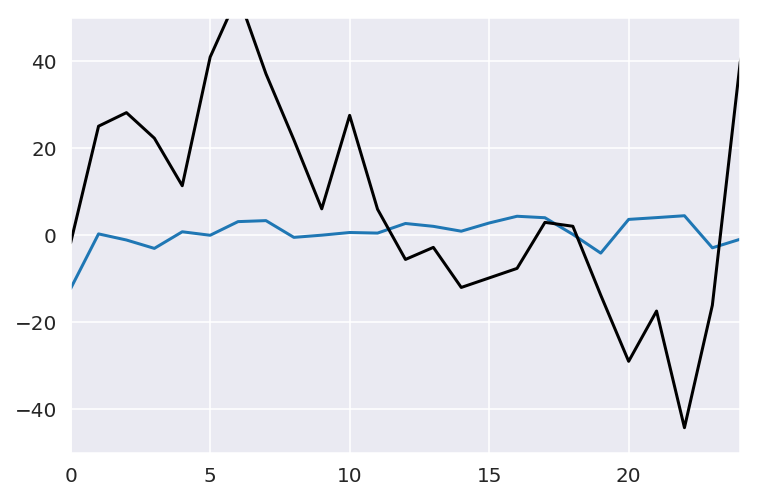

In [30]:
plt.plot(arima_model_results.predict(33096, 33096+1000),)
plt.plot(Y_test.values - xgbf.predict(X_test), color='k')
plt.xlim(0, 24)
plt.ylim(-50, 50)

This seems to produce an exponential decay type result, which is *not particularly useful*.

### SARIMAX Model -- does not run

This crashes my Jupyter Kernel

In [23]:
# This crashes my Jupyter Kernel
# sarimax_results = smf.tsa.statespace.SARIMAX(Y_train.values, order=(2, 1, 2), seasonal_order=(1, 0, 1, 365*24), simple_differencing=True)#, exog=X_train.values)
# sarimax_results.fit(disp=20)

# Keras Models

### High Level Strategy

To perform well, the model probably needs 

1. Daily mean PM2.5 at this point last year
2. Daily Diurnal (24 hour) variance or standard deviation.
3. Hourly PM2.5 over last week

The optimal network will also probably need to be a multi-input network, as these inputs will all have different shapes.

Some of the features in `df` above make sense to take these operations of (e.g. accumulated wind speed). Others do not (e.g. annual sin, cos).

## Dense model -- Time Naive

#### Dense model preprocessing of data

In [24]:
X_train.describe()

DEWP          TEMP          PRES           Iws            Is  \
count  35040.000000  35040.000000  35040.000000  35040.000000  35040.000000   
mean       1.772603     12.153910   1016.399780     24.963224      0.057477   
std       14.494914     12.307034     10.386205     51.315742      0.773838   
min      -33.000000    -19.000000    991.000000      0.450000      0.000000   
25%      -11.000000      1.000000   1008.000000      1.790000      0.000000   
50%        2.000000     13.000000   1016.000000      5.810000      0.000000   
75%       15.000000     23.000000   1025.000000     23.250000      0.000000   
max       28.000000     41.000000   1046.000000    585.599976     27.000000   

                 Ir    Annual_Cos    Annual_Sin      weekday            NE  \
count  35040.000000  3.504000e+04  3.504000e+04  35040.00000  35040.000000   
mean       0.209874 -3.483742e-09  0.000000e+00      3.00000      0.113955   
std        1.489928  7.071168e-01  7.071168e-01      2.00174      0.317762   
min        0.000000 -9.999630e-01 -9.999908e-01      0.00000      0.000000   
25%        0.000000 -7.086267e-01 -7.055836e-01      1.00000      0.000000   
50%        0.000000  4.303538e-03 -2.449294e-16      3.00000      0.000000   
75%        0.000000  7.025275e-01  7.055836e-01      5.00000      0.000000   
max       36.000000  1.000000e+00  9.999908e-01      6.00000      1.000000   

                 NW            SE            cv  
count  35040.000000  35040.000000  35040.000000  
mean       0.333162      0.344406      0.208476  
std        0.471351      0.475181      0.406225  
min        0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000  
75%        1.000000      1.000000      0.000000  
max        1.000000      1.000000      1.000000

In [25]:
robust_scaler = sklearn.preprocessing.RobustScaler()

In [26]:
df2 = df[X_cols].copy()

In [27]:
df2.iloc[:, :] = robust_scaler.fit_transform(df2.astype(np.float32))

In [28]:
df2.head()

DEWP      TEMP      PRES       Iws   Is   Ir  Annual_Cos  \
2010-01-02 00:00:00 -0.72 -0.857143  0.235294 -0.177932  0.0  0.0     0.70517   
2010-01-02 01:00:00 -0.68 -0.857143  0.235294 -0.133698  0.0  0.0     0.70517   
2010-01-02 02:00:00 -0.52 -0.904762  0.294118 -0.089463  0.0  0.0     0.70517   
2010-01-02 03:00:00 -0.36 -0.904762  0.352941 -0.000497  1.0  0.0     0.70517   
2010-01-02 04:00:00 -0.36 -0.904762  0.352941  0.043738  2.0  0.0     0.70517   

                     Annual_Sin  weekday   NE   NW   SE   cv  
2010-01-02 00:00:00    0.024392      0.5  0.0  0.0  1.0  0.0  
2010-01-02 01:00:00    0.024392      0.5  0.0  0.0  1.0  0.0  
2010-01-02 02:00:00    0.024392      0.5  0.0  0.0  1.0  0.0  
2010-01-02 03:00:00    0.024392      0.5  0.0  0.0  1.0  0.0  
2010-01-02 04:00:00    0.024392      0.5  0.0  0.0  1.0  0.0

In [33]:
df2.shape

(43800, 16)

In [34]:
Y = df['pm2.5']
in_train_set = X.index < '2014-01-01'

X_train, X_test = df2[in_train_set], df2[~in_train_set]
Y_train, Y_test = Y[in_train_set], Y[~in_train_set]

#### Dense model definition and training

In [35]:
dense_model = keras.Sequential()
dense_model.add(L.Dense(128, input_shape=(df2.shape[1],)))
dense_model.add(L.Dense(128))
dense_model.add(L.Dropout(0.5))
dense_model.add(L.Dense(256))
dense_model.add(L.Dense(256))
dense_model.add(L.Dropout(0.5))
dense_model.add(L.Dense(128))
dense_model.add(L.Dense(64))
dense_model.add(L.Dense(32))
dense_model.add(L.Dense(1, activation='linear'))
dense_model.compile(loss='mean_squared_error', optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [36]:
dense_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2176      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
__________

In [37]:
dense_model.fit(X_train.values, Y_train.values, batch_size=200, 
                steps_per_epoch=40, epochs=25)

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
40/40 [==============================] - 13s 333ms/step - loss: 6983.4442
Epoch 2/25
40/40 [==============================] - 14s 343ms/step - loss: 1263.1852
Epoch 3/25
40/40 [==============================] - 15s 368ms/step - loss: 882.7699
Epoch 4/25
40/40 [==============================] - 14s 344ms/step - loss: 776.0849
Epoch 5/25
40/40 [==============================] - 14s 341ms/step - loss: 736.6447
Epoch 6/25
40/40 [==============================] - 13s 330ms/step - loss: 711.9349
Epoch 7/25
40/40 [==============================] - 12s 312ms/step - loss: 697.3109
Epoch 8/25
40/40 [==============================] - 12s 310ms/step - loss: 685.5970
Epoch 9/25
40/40 [==============================] - 12s 301ms/step - loss: 676.5647
Epoch 10/25
40/40 [==============================] - 12s 299ms/step - loss: 671.7295
Epoch 11/25
40/40 [==============================] - 12s 309ms/step - loss: 660.3595
Epoch 12/25
40/40 [=====

In [38]:
sklearn.metrics.r2_score(Y_test.values, dense_model.predict(X_test).ravel())

0.9435373800614542

The $R^2$ is slightly worse, but prety close to the XGBoost model.

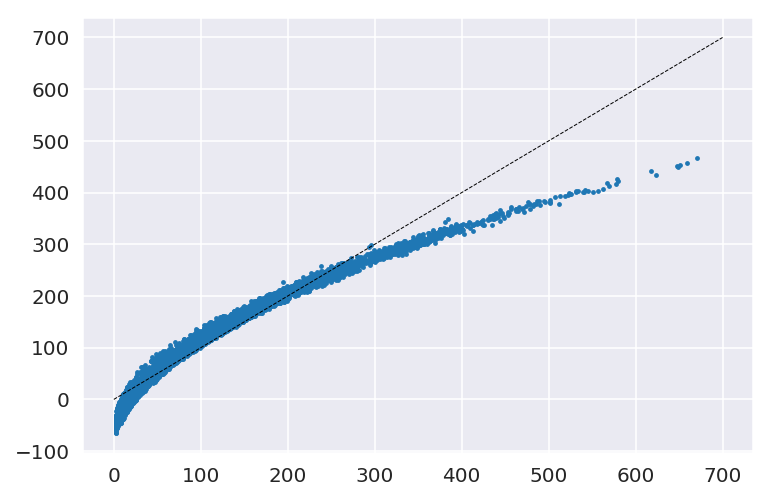

In [59]:
plt.scatter(Y_test.values, dense_model.predict(X_test).ravel(), s=2)
plt.plot([0, 700], [0, 700], color='k', lw=0.5, linestyle='--')

That's super weird, and looks like there's a mistake somewhere.

## LSTM Model

In [43]:
df.head()

pm2.5  DEWP  TEMP    PRES   Iws  Is  Ir  Annual_Cos  \
2010-01-02 00:00:00  129.0   -16  -4.0  1020.0  1.79   0   0    0.999407   
2010-01-02 01:00:00  148.0   -15  -4.0  1020.0  2.68   0   0    0.999407   
2010-01-02 02:00:00  159.0   -11  -5.0  1021.0  3.57   0   0    0.999407   
2010-01-02 03:00:00  181.0    -7  -5.0  1022.0  5.36   1   0    0.999407   
2010-01-02 04:00:00  138.0    -7  -5.0  1022.0  6.25   2   0    0.999407   

                     Annual_Sin  Daily_Cos  Daily_Sin  weekday  NE  NW  SE  cv  
2010-01-02 00:00:00    0.034422   1.000000   0.000000        5   0   0   1   0  
2010-01-02 01:00:00    0.034422   0.965926   0.258819        5   0   0   1   0  
2010-01-02 02:00:00    0.034422   0.866025   0.500000        5   0   0   1   0  
2010-01-02 03:00:00    0.034422   0.707107   0.707107        5   0   0   1   0  
2010-01-02 04:00:00    0.034422   0.500000   0.866025        5   0   0   1   0

In [44]:
df2 = df.copy()

In [45]:
# manual rescaling of features
df2['pm2.5'] = (df2['pm2.5']**0.5) / 10.
df2['DEWP'] /= 30
df2['TEMP'] /= 30
df2['PRES'] = (df2.PRES-1000)/30.
df2['Iws'] = df2.Iws**0.5
df2['weekday'] /= 6

In [46]:
Y = df['pm2.5'].copy()
in_train_set = X.index < '2014-01-01'

X_train, X_test = df2[in_train_set].copy(), df2[~in_train_set].copy()
Y_train, Y_test = Y[in_train_set], Y[~in_train_set]

In [47]:
X_train.columns

Index(['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'Annual_Cos',
       'Annual_Sin', 'Daily_Cos', 'Daily_Sin', 'weekday', 'NE', 'NW', 'SE',
       'cv'],
      dtype='object')

In [48]:
def lstm_batch_generator(random_state=32, batch_size=20):
    rs_ = np.random.RandomState(random_state)
    
    LOOKBACK = 7*24
    LOOKFORWARD = 24
    
    train_N = X_train.shape[0]

    training_example_lower_bound = LOOKBACK
    training_example_upper_bound = train_N - LOOKFORWARD
    
    while True:
        indexes = np.sort(rs_.randint(training_example_lower_bound, 
                              training_example_upper_bound, 
                              size=batch_size))

        # we only want to split days at midnight, to be consistent with how we evaluate
        indexes = (np.round(indexes/24, 0) * 24).astype(int)
        
        new_X = np.zeros((batch_size, LOOKBACK, X_train.shape[1]), dtype=np.float32)
        new_Y = np.zeros((batch_size, LOOKFORWARD), dtype=np.float32)

        for i, idx in enumerate(indexes):
            new_X[i] = X_train.iloc[idx-LOOKBACK:idx, :]
            
            new_Y[i] = X_train['pm2.5'].iloc[idx:idx+LOOKFORWARD]
            
        yield new_X.copy(), new_Y.copy()

#### Only the LSTM -- 1 week lookback

In [54]:
lstm1_model = keras.Sequential()
lstm1_model.add(L.LSTM(128, return_sequences=True, input_shape=(7 * 24, X_train.shape[1]))) # one week of data
lstm1_model.add(L.LSTM(128, return_sequences=True))
lstm1_model.add(L.LSTM(128, return_sequences=False))
lstm1_model.add(L.Dense(128))
lstm1_model.add(L.Dropout(0.5))
lstm1_model.add(L.Dense(128))
lstm1_model.add(L.Dropout(0.5))
lstm1_model.add(L.Dense(128))
lstm1_model.add(L.Dense(24, activation='linear'))
lstm1_model.compile(loss='mean_squared_error', optimizer='adam')

In [55]:
lstm1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 168, 128)          74240     
_________________________________________________________________
lstm_4 (LSTM)                (None, 168, 128)          131584    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
__________

In [56]:
H = lstm1_model.fit_generator(lstm_batch_generator(random_state=42, batch_size=20), steps_per_epoch=5, 
                              epochs=25, shuffle=False)

Epoch 1/25
5/5 [==============================] - 26s 5s/step - loss: 0.7782
Epoch 2/25
5/5 [==============================] - 22s 4s/step - loss: 0.4730
Epoch 3/25
5/5 [==============================] - 22s 4s/step - loss: 0.2939
Epoch 4/25
5/5 [==============================] - 21s 4s/step - loss: 0.3037
Epoch 5/25
5/5 [==============================] - 21s 4s/step - loss: 0.2275
Epoch 6/25
5/5 [==============================] - 23s 5s/step - loss: 0.2386
Epoch 7/25
5/5 [==============================] - 28s 6s/step - loss: 0.2084
Epoch 8/25
5/5 [==============================] - 23s 5s/step - loss: 0.2035
Epoch 9/25
5/5 [==============================] - 21s 4s/step - loss: 0.1739
Epoch 10/25
5/5 [==============================] - 23s 5s/step - loss: 0.1929
Epoch 11/25
5/5 [==============================] - 21s 4s/step - loss: 0.1867
Epoch 12/25
5/5 [==============================] - 24s 5s/step - loss: 0.1580
Epoch 13/25
5/5 [==============================] - 21s 4s/step - loss: 0.

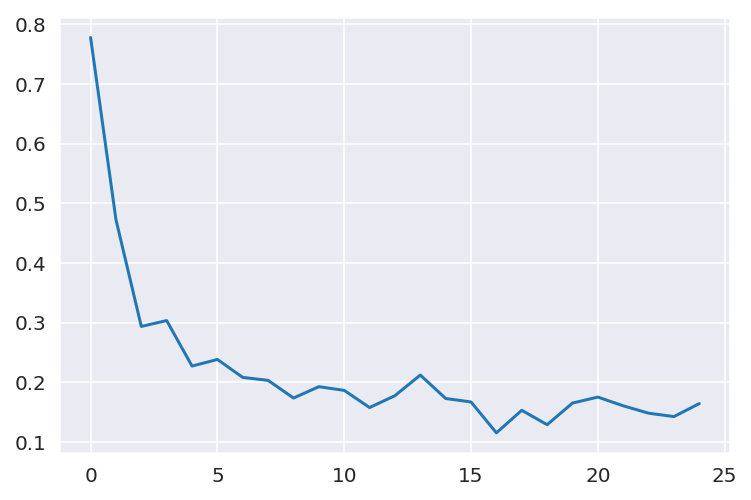

In [57]:
plt.plot(H.history['loss']);

In [58]:
X_test.head()

pm2.5      DEWP      TEMP      PRES        Iws  Is  \
2014-01-01 00:00:00  0.489898 -0.666667  0.233333  0.466667  11.978314   0   
2014-01-01 01:00:00  0.728011 -0.666667  0.233333  0.433333  12.144958   0   
2014-01-01 02:00:00  0.806226 -0.666667  0.200000  0.433333  12.309346   0   
2014-01-01 03:00:00  0.836660 -0.666667  0.200000  0.433333  12.381842   0   
2014-01-01 04:00:00  0.888819 -0.600000  0.100000  0.400000   0.943398   0   

                     Ir  Annual_Cos  Annual_Sin  Daily_Cos  Daily_Sin  \
2014-01-01 00:00:00   0    0.999852    0.017213   1.000000   0.000000   
2014-01-01 01:00:00   0    0.999852    0.017213   0.965926   0.258819   
2014-01-01 02:00:00   0    0.999852    0.017213   0.866025   0.500000   
2014-01-01 03:00:00   0    0.999852    0.017213   0.707107   0.707107   
2014-01-01 04:00:00   0    0.999852    0.017213   0.500000   0.866025   

                      weekday  NE  NW  SE  cv  
2014-01-01 00:00:00  0.333333   0   1   0   0  
2014-01-01 01:00:00  0.333333   0   1   0   0  
2014-01-01 02:00:00  0.333333   0   1   0   0  
2014-01-01 03:00:00  0.333333   0   1   0   0  
2014-01-01 04:00:00  0.333333   0   0   0   1

In [60]:
def evaluate_lstm_model():
    test_set_days = pd.date_range('2014-01-01 00:00:00', df2.index.max(), freq='24H')
    
    day_midnight_indices = df2['pm2.5'].copy().astype(np.int64)
    day_midnight_indices.values[:] = np.arange(len(day_midnight_indices))
    day_midnight_indices = day_midnight_indices[day_midnight_indices.index.isin(test_set_days)]
    
    LOOKBACK = 7 * 24
    LOOKFORWARD = 24
    
    new_X = np.zeros((len(test_set_days), LOOKBACK, df2.shape[1]), dtype=np.float32)
    new_Y = np.zeros((len(test_set_days), LOOKFORWARD), dtype=np.float32)

    for i, idx in enumerate(day_midnight_indices):
        new_X[i] = df2.iloc[idx-LOOKBACK:idx, :]
        new_Y[i] = df2['pm2.5'].iloc[idx:idx+LOOKFORWARD]
    
    return new_X, new_Y

In [61]:
X2, Y2 = evaluate_lstm_model()

In [62]:
Yhat_2 = lstm1_model.predict(X2).ravel()
Yhat_2 = (Yhat_2*10)**2

In [63]:
Yhat_2

array([17.226233, 24.119173, 22.04561 , ..., 62.414055, 67.792114,
       61.092026], dtype=float32)

In [64]:
print(Y_test.values)

[24. 53. 65. ... 10.  8. 12.]


In [65]:
sklearn.metrics.r2_score(Y_test.values, Yhat_2)

0.3644510563765707

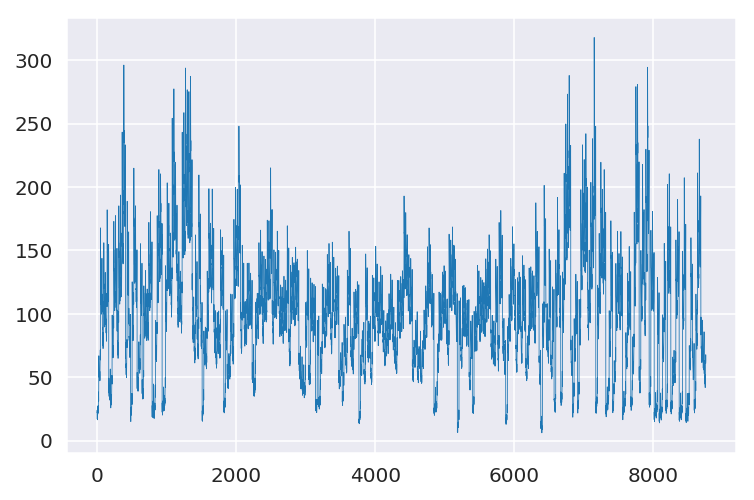

In [66]:
plt.plot(Yhat_2, lw=0.4)